In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from hmmlearn import hmm
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.fftpack import fft
import pywt

In [58]:
# ==== Load data ====
train_df = pd.read_csv('Sleep Train 5000.csv', header=None)
test_df = pd.read_csv('Sleep Test 1000.csv', header=None)

In [ ]:
# ==== Fix shape mismatch if needed ====
X_train_full = train_df.iloc[:, 1:].values
y_train_full = train_df.iloc[:, 0].values
X_test = test_df.values
if X_test.shape[1] < X_train_full.shape[1]:
    X_test = np.hstack((X_test, np.zeros((X_test.shape[0], 1))))

In [60]:
# ==== Encode labels ====
le = LabelEncoder()
y_train_full = le.fit_transform(y_train_full)

In [61]:
# ==== Train/Validation Split ====
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

In [62]:
# ==== Scale features ====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [63]:
def explore_data(df, name="Dataset"):
    print(f"=== {name} Exploration ===")
    print(f"Shape: {df.shape}")
    
    # Check class distribution
    class_counts = df[0].value_counts()
    print(f"\nClass distribution:")
    print(class_counts)
    print(f"Number of unique classes: {len(class_counts)}")
    
    # Check for missing values
    print(f"\nMissing values: {df.isnull().sum().sum()}")
    
    # Basic statistics of time series
    print(f"\nBasic statistics of first few features:")
    print(df.iloc[:, 1:6].describe())
    
    return class_counts

train_classes = explore_data(train_df, "Training Data")

=== Training Data Exploration ===
Shape: (4999, 179)

Class distribution:
0
2    2000
3    1040
4     751
1     697
0     511
Name: count, dtype: int64
Number of unique classes: 5

Missing values: 0

Basic statistics of first few features:
                 1            2            3            4            5
count  4999.000000  4999.000000  4999.000000  4999.000000  4999.000000
mean     -0.554607    -0.564193    -0.540193    -0.649433    -0.753712
std      17.789305    17.597088    17.681466    17.723401    17.403211
min    -146.094760   -82.371185   -81.849570   -90.543100   -90.803910
25%      -9.345543    -9.258608    -9.519414    -9.693284    -9.432479
50%      -0.391209    -0.652015    -0.652015    -0.738950    -0.738950
75%       8.062149     8.041514     8.215385     8.215385     7.883883
max     105.409035    95.585350    91.934070   109.668860    87.065690


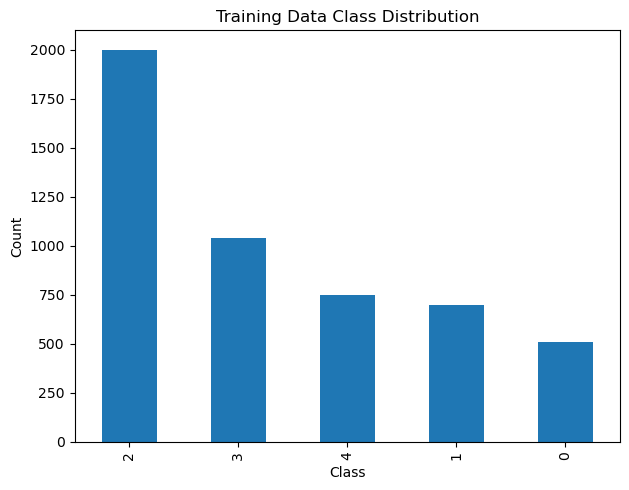

In [64]:
# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_classes.plot(kind='bar')
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('class_distribution.png')

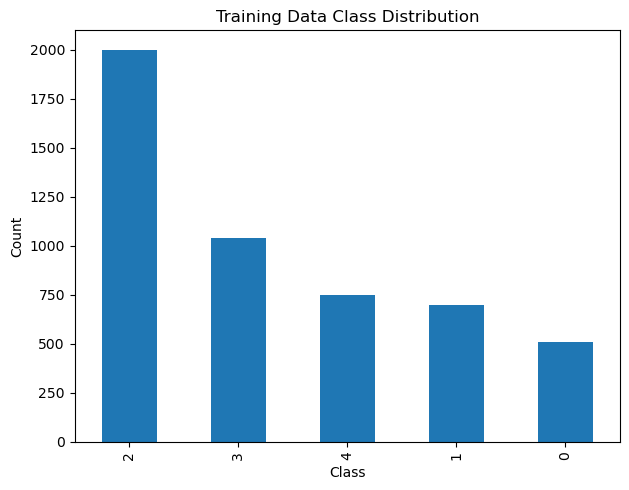

In [65]:
# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_classes.plot(kind='bar')
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('class_distribution.png')

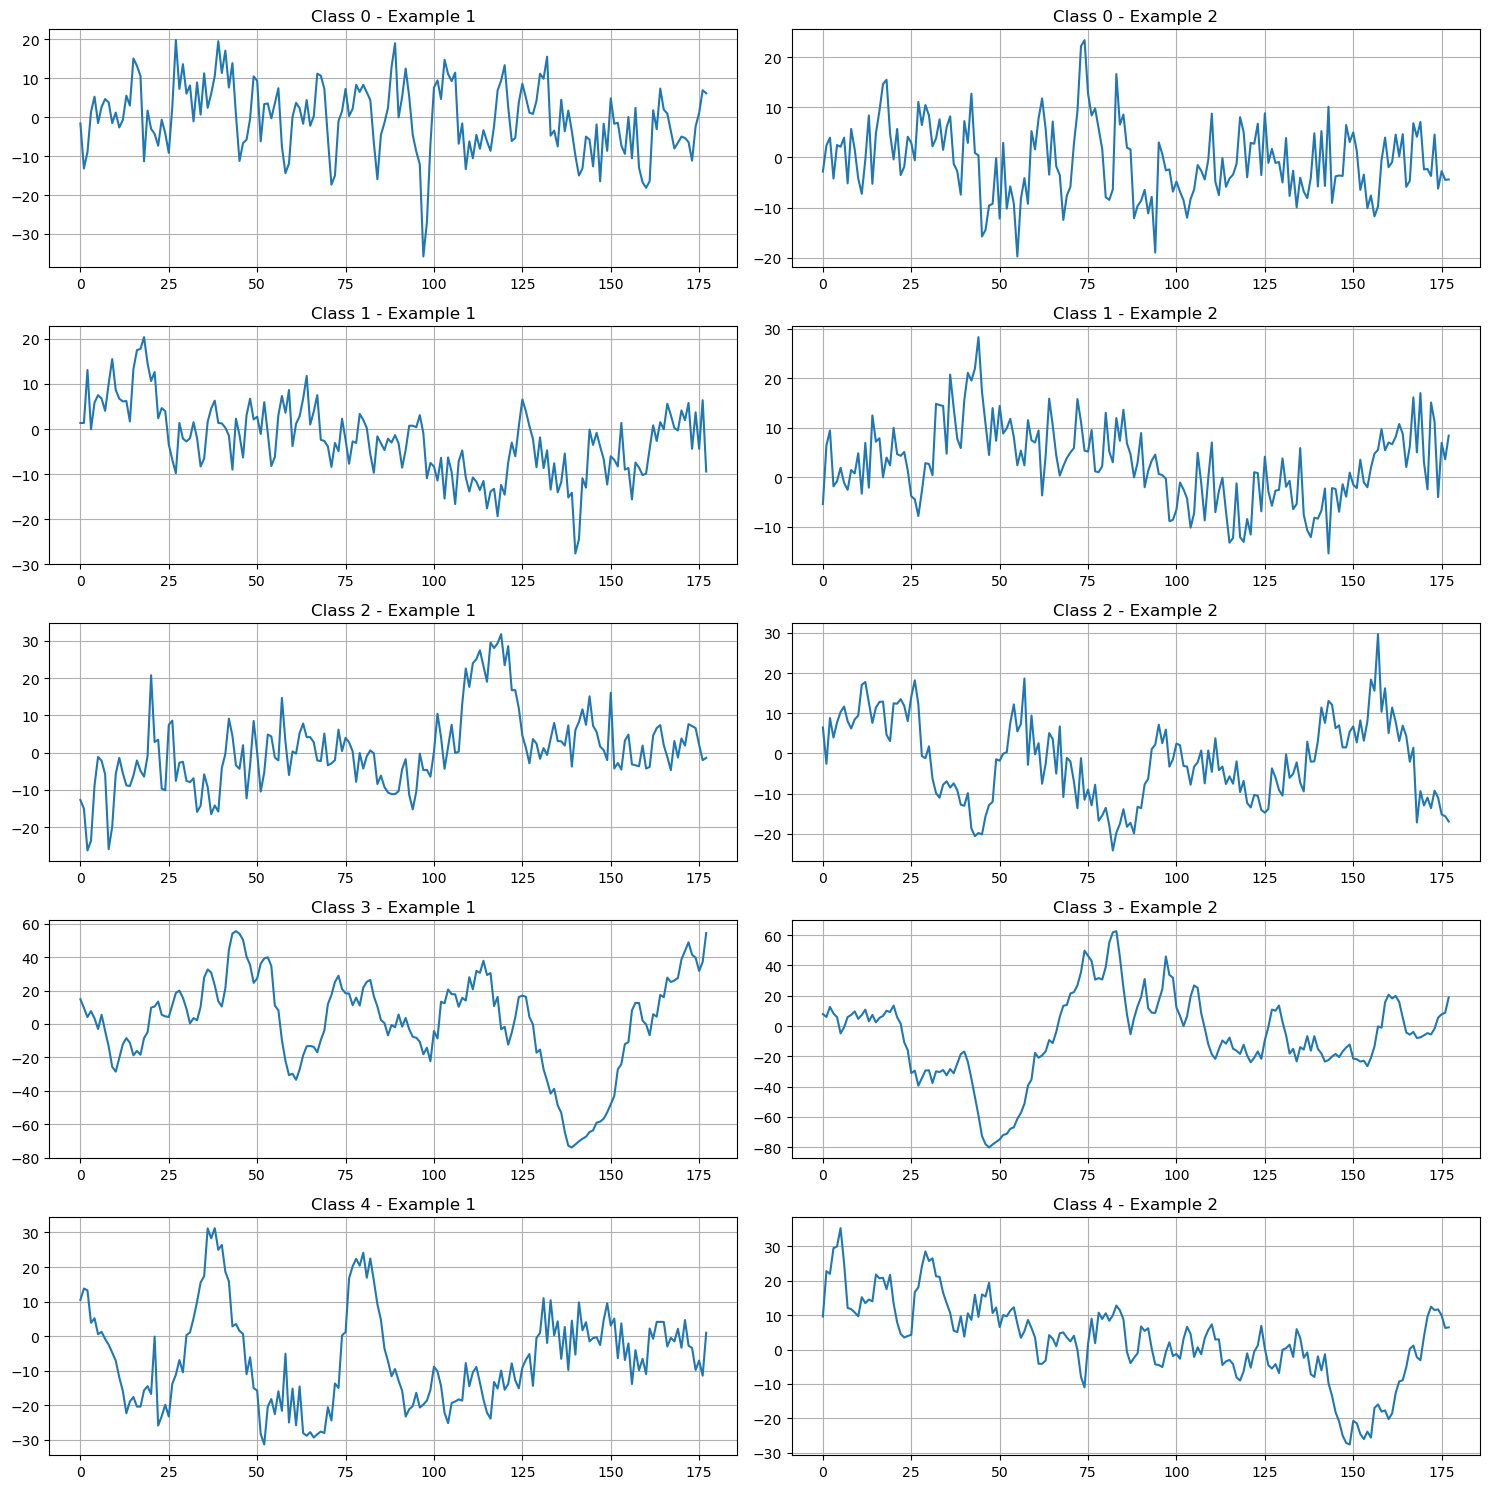

In [66]:
X_train_raw = train_df.iloc[:, 1:].values
y_train_raw = train_df.iloc[:, 0].values

# Visualize a few examples from each class
def plot_examples(X, y, n_examples=2):
    classes = np.unique(y)
    plt.figure(figsize=(15, len(classes)*3))
    
    for i, cls in enumerate(classes):
        class_indices = np.where(y == cls)[0]
        
        # Take n_examples from this class (or all if fewer)
        n_to_plot = min(n_examples, len(class_indices))
        indices_to_plot = class_indices[:n_to_plot]
        
        for j, idx in enumerate(indices_to_plot):
            plt.subplot(len(classes), n_examples, i*n_examples + j + 1)
            plt.plot(X[idx])
            plt.title(f'Class {cls} - Example {j+1}')
            plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('class_examples.png')

plot_examples(X_train_raw, y_train_raw)

In [67]:
# --- Custom Feature Extraction Functions ---

# 1. Statistical Features
def extract_stats(X):
    """Extract comprehensive statistical features"""
    features = []
    
    for signal in X:
        # Basic statistics
        mean = np.mean(signal)
        std = np.std(signal)
        var = np.var(signal)
        mini = np.min(signal)
        maxi = np.max(signal)
        rng = maxi - mini
        median = np.median(signal)
        
        # Higher-order statistics
        skew = 0
        if std > 0:
            skew = np.mean(((signal - mean) / std) ** 3)
        
        kurtosis = 0
        if std > 0:
            kurtosis = np.mean(((signal - mean) / std) ** 4) - 3
        
        # Peaks and crossings
        zero_crossings = np.sum(np.diff(np.signbit(signal - np.mean(signal))))
        peaks = np.sum(np.diff(np.signbit(np.diff(signal))) < 0)
        
        # First-order differences
        diffs = np.diff(signal)
        mean_diff = np.mean(diffs)
        std_diff = np.std(diffs)
        
        # Energy and power
        energy = np.sum(signal ** 2)
        power = energy / len(signal)
        
        # Quantiles
        q25 = np.percentile(signal, 25)
        q75 = np.percentile(signal, 75)
        iqr = q75 - q25
        
        # Put all features together
        feat = [mean, std, var, mini, maxi, rng, median, skew, kurtosis, 
                zero_crossings, peaks, mean_diff, std_diff, energy, power,
                q25, q75, iqr]
        
        features.append(feat)
    
    return np.array(features)

In [68]:
# 2. Frequency Domain Features
def extract_fft_features(X, n_coeffs=50):
    """Extract richer frequency domain features"""
    features = []
    
    for signal in X:
        # Apply FFT
        fft_values = np.abs(fft(signal))
        
        # Get dominant frequencies (top n_coeffs)
        dominant_freqs = fft_values[:n_coeffs]
        
        # Frequency band power
        total_power = np.sum(fft_values ** 2)
        
        # Divide spectrum into bands and calculate power in each band
        n_bands = 5
        band_size = len(fft_values) // n_bands
        band_powers = []
        
        for i in range(n_bands):
            start = i * band_size
            end = (i + 1) * band_size if i < n_bands - 1 else len(fft_values)
            band_power = np.sum(fft_values[start:end] ** 2) / total_power
            band_powers.append(band_power)
        
        # Spectrum statistics
        fft_mean = np.mean(fft_values)
        fft_std = np.std(fft_values)
        fft_max = np.max(fft_values)
        fft_peak_idx = np.argmax(fft_values)
        
        # Combine all frequency features
        feat = np.concatenate([
            dominant_freqs,
            band_powers,
            [fft_mean, fft_std, fft_max, fft_peak_idx]
        ])
        
        features.append(feat)
    
    return np.array(features)

In [69]:
# 3. Wavelet Features
def extract_wavelet_features(X, wavelet='db4', level=4):
    """Extract comprehensive wavelet features"""
    features = []
    
    for signal in X:
        # Perform wavelet decomposition
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        
        # Extract features from each coefficient level
        wavelet_features = []
        
        for coef in coeffs:
            # Basic statistics
            mean = np.mean(coef)
            std = np.std(coef)
            energy = np.sum(coef ** 2)
            
            # Add these statistics to features
            wavelet_features.extend([mean, std, energy])
        
        features.append(wavelet_features)
    
    return np.array(features)

In [70]:
# Extract all features
print("Extracting statistical features...")
X_train_stats = extract_stats(X_train_raw)

print("Extracting FFT features...")
X_train_fft = extract_fft_features(X_train_raw)

print("Extracting wavelet features...")
X_train_wave = extract_wavelet_features(X_train_raw)

Extracting statistical features...
Extracting FFT features...
Extracting wavelet features...


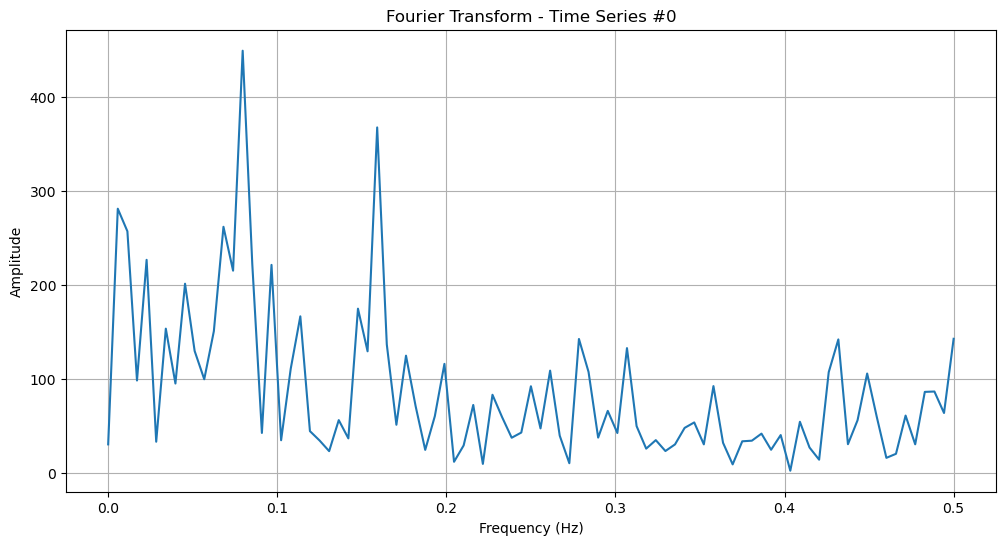

In [71]:
def perform_fft(signal):
    N = len(signal)
    T = 1.0  # Assuming 1 Hz sampling frequency; change this if needed
    yf = np.abs(fft(signal))[:N // 2]
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
    return xf, yf

def plot_fft(xf, yf, title):
    plt.figure(figsize=(12, 6))
    plt.plot(xf, yf)
    plt.title(f'Fourier Transform - {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()
    
# Plot FFT of signal at index 0
idx = 0  # Change this to any index you want to visualize
signal = X_train_raw[idx]
xf, yf = perform_fft(signal)
plot_fft(xf, yf, f'Time Series #{idx}')

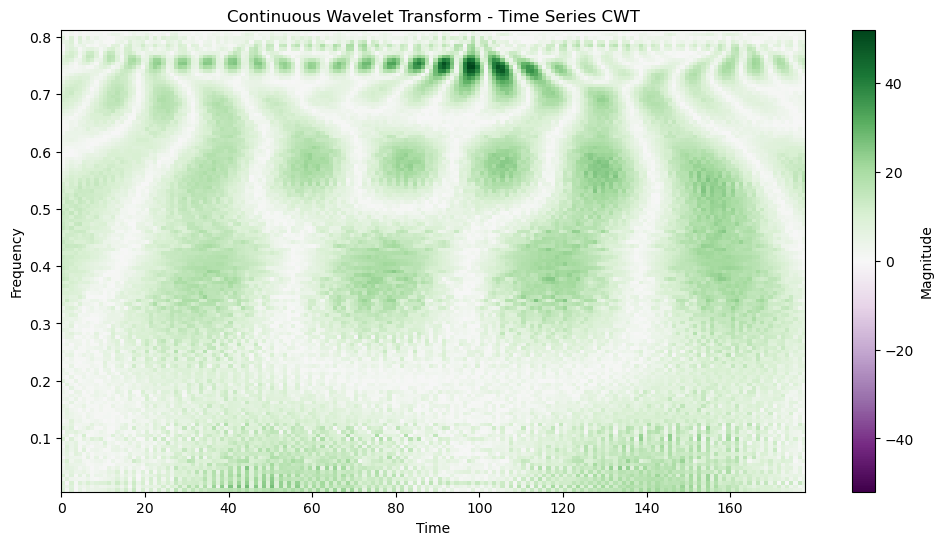

In [72]:
def plot_wavelet(signal, wavelet_name='morl'):
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name)
    plot_cwt(signal, coefficients, frequencies, f'Time Series CWT')

# Visualize the same example time series
plot_wavelet(signal)

In [89]:
# ==== Train Models ====
models = {}

# Naive Bayes
models['Naive Bayes'] = GaussianNB().fit(X_train, y_train)

# Gradient Boosting
models['Gradient Boosting'] = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

# MLP
models['MLP'] = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42).fit(X_train, y_train)

# XGBoost
models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss').fit(X_train, y_train)

# TimeSeries Forest (sktime)
X_train_nested = from_2d_array_to_nested(X_train)
X_val_nested = from_2d_array_to_nested(X_val)
ts_forest = TimeSeriesForestClassifier(n_estimators=100, random_state=42)
ts_forest.fit(X_train_nested, y_train)
models['TimeSeries Forest'] = ts_forest


# ==== Evaluate on validation ====
print("\nValidation Accuracies:")
for name, model in models.items():
    if name == 'TimeSeries Forest':
        val_preds = model.predict(X_val_nested)
    else:
        val_preds = model.predict(X_val)

    print(f"{name}: {accuracy_score(y_val, val_preds):.3f}")

C:\Users\raven\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\raven\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:47:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Validation Accuracies:
Naive Bayes: 0.409
Gradient Boosting: 0.539
MLP: 0.486
XGBoost: 0.545
TimeSeries Forest: 0.562


In [91]:
# Predict test labels
nb_preds = le.inverse_transform(models['Naive Bayes'].predict(X_test))
mlp_preds = le.inverse_transform(models['MLP'].predict(X_test))
gb_preds = le.inverse_transform(models['Gradient Boosting'].predict(X_test))
xgb_preds = le.inverse_transform(models['XGBoost'].predict(X_test))
tsf_preds = le.inverse_transform(models['TimeSeries Forest'].predict(X_train_nested))

# Save predictions
pd.DataFrame(nb_preds).to_csv("naive_bayes_predictions.csv", index=False, header=False)
pd.DataFrame(mlp_preds).to_csv("mlp_predictions.csv", index=False, header=False)
pd.DataFrame(gb_preds).to_csv("gb_predictions.csv", index=False, header=False)
pd.DataFrame(xgb_preds).to_csv("xgboost_predictions.csv", index=False, header=False)
pd.DataFrame(tsf_preds).to_csv("timeseriesforest_predictions.csv", index=False, header=False)

print("Done, predictions saved.")

Done, predictions saved.
